In [1]:
import pandas as pd
import string
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
products = pd.read_csv('amazon_baby_subset.csv')

In [3]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]','',text) 

In [4]:
products['review'] = products.review.fillna('')

In [5]:
products['review_clean'] = products.review.apply(lambda x: remove_punctuation(x))

In [6]:
products.shape

(53072, 5)

In [7]:
important_words = pd.read_json('important_words.json')

In [8]:
important_words = important_words[0].tolist()
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [9]:
products.shape

(53072, 198)

In [10]:
train_idx = pd.read_json('module-10-assignment-train-idx.json')
validation_idx = pd.read_json('module-10-assignment-validation-idx.json')

In [11]:
train_data = products.iloc[train_idx[0]]
validation_data = products.iloc[validation_idx[0]]

In [12]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    feature_frame = dataframe[features]
    feature_matrix = feature_frame.to_numpy()
    label_sarray = dataframe[label]
    label_array = label_sarray.to_numpy()
    return (feature_matrix, label_array)

In [13]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
feature_matrix_train.shape

(47780, 194)

In [15]:
def predict_probability(feature_matrix, coefficients):
    import math
    score = np.dot(feature_matrix, coefficients)
    predictions = 1. /(1 + np.exp(-score))
    
    return predictions

In [16]:
def feature_derivative(errors,feature):
    derivative = np.dot(errors, feature)    
    return derivative

In [17]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = 1/len(feature_matrix)  * np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores)))
    
    return lp

In [18]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print ("Gradient single data point: %s" % gradient_single_data_point)
print ("           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


In [19]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print ("Gradient mini-batch data points: %s" % gradient_mini_batch)
print ("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


In [20]:
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    
    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i:i+batch_size,:], coefficients)
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator = (sentiment[i:i+batch_size]==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j])
            
            # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] += (1./batch_size)*(step_size * derivative)
        
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print( 'Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))
        
        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [21]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print ('-------------------------------------------------------------------------------------')
print ('Coefficients learned                 :', coefficients)
print ('Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print ('-------------------------------------------------------------------------------------')
    print ('Test passed!')
else:
    print ('-------------------------------------------------------------------------------------')
    print ('Test failed')

Iteration 0: Average log likelihood (of data points in batch [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points in batch [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


In [22]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points in batch [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points in batch [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points in batch [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points in batch [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points in batch [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points in batch [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points in batch [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points in batch [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points in batch [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points in batch [00009:00010]) = -0.00000124


In [23]:
log_likelihood

[-0.25192908134537295,
 -8.5024389389541e-09,
 -0.12692771260639515,
 -0.029691014785741033,
 -0.026688191711023244,
 -0.04332900876420492,
 -0.02368801782547734,
 -0.12686897415874332,
 -0.044688785447222955,
 -1.2350307603270494e-06]

In [24]:
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, 
                                        batch_size = len(feature_matrix_train), 
                                        max_iter=200)

Iteration   0: Average log likelihood (of data points in batch [00000:47780]) = -0.68308113
Iteration   1: Average log likelihood (of data points in batch [00000:47780]) = -0.67394588
Iteration   2: Average log likelihood (of data points in batch [00000:47780]) = -0.66555115
Iteration   3: Average log likelihood (of data points in batch [00000:47780]) = -0.65779607
Iteration   4: Average log likelihood (of data points in batch [00000:47780]) = -0.65060679
Iteration   5: Average log likelihood (of data points in batch [00000:47780]) = -0.64392216
Iteration   6: Average log likelihood (of data points in batch [00000:47780]) = -0.63768981
Iteration   7: Average log likelihood (of data points in batch [00000:47780]) = -0.63186430
Iteration   8: Average log likelihood (of data points in batch [00000:47780]) = -0.62640601
Iteration   9: Average log likelihood (of data points in batch [00000:47780]) = -0.62128025
Iteration  10: Average log likelihood (of data points in batch [00000:47780]) = 

In [25]:
log_likelihood_batch

[-0.6830811323910639,
 -0.6739458848781833,
 -0.6655511454281972,
 -0.6577960744152077,
 -0.6506067850198535,
 -0.6439221585992218,
 -0.6376898069020369,
 -0.6318642992042596,
 -0.6264060142300358,
 -0.6212802531898776,
 -0.6164565153555592,
 -0.6119078961680835,
 -0.6076105836123965,
 -0.6035434348786485,
 -0.5996876190924506,
 -0.5960263146592699,
 -0.5925444519331007,
 -0.5892284936453811,
 -0.5860662469126168,
 -0.5830467017516955,
 -0.5801598919265916,
 -0.5773967746735142,
 -0.5747491264386483,
 -0.5722094522410364,
 -0.5697709066646042,
 -0.5674272248048868,
 -0.5651726617611947,
 -0.5630019394844583,
 -0.5609101999733053,
 -0.558892963962891,
 -0.5569460943780454,
 -0.5550657639288675,
 -0.553248426316512,
 -0.5514907905925165,
 -0.5497897982789353,
 -0.5481426029107516,
 -0.5465465517080977,
 -0.5449991691250597,
 -0.5434981420553321,
 -0.5420413065036767,
 -0.5406266355567064,
 -0.5392522285076465,
 -0.5379163010079179,
 -0.5366171761340748,
 -0.5353532762722045,
 -0.53412311

In [26]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)
print(num_iterations)
coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

4770
Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [

In [27]:
log_likelihood_sgd

[-0.682510928565563,
 -0.6784529438009901,
 -0.6820716036260345,
 -0.6741132500973214,
 -0.6780443812596296,
 -0.677125460563647,
 -0.6637707429859404,
 -0.673212314280629,
 -0.6692361275930966,
 -0.6747944604200596,
 -0.6650163900485417,
 -0.6559196355871174,
 -0.6624039755374505,
 -0.6644064146666301,
 -0.6578275697556775,
 -0.6457147888416596,
 -0.6699070363543193,
 -0.6464022967692381,
 -0.6610797379140125,
 -0.6596317002706141,
 -0.6451823364362614,
 -0.651849273903578,
 -0.6513970471672847,
 -0.6629297908544328,
 -0.6375261376223641,
 -0.6435922679781869,
 -0.6447706257779627,
 -0.6512321330138837,
 -0.6522372551861996,
 -0.6332224313838025,
 -0.6455903526381025,
 -0.64034555370463,
 -0.644856669920209,
 -0.6418987756740202,
 -0.6334834956263992,
 -0.6244691000563718,
 -0.6161028871678488,
 -0.6538045953836543,
 -0.6114467956712752,
 -0.6513314832955728,
 -0.6327313449971679,
 -0.6211442901534685,
 -0.6235964140993243,
 -0.6211297350894357,
 -0.6123725253727311,
 -0.6274714202164

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})


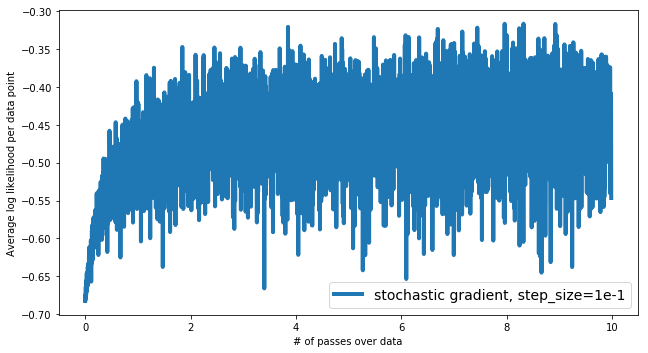

In [29]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

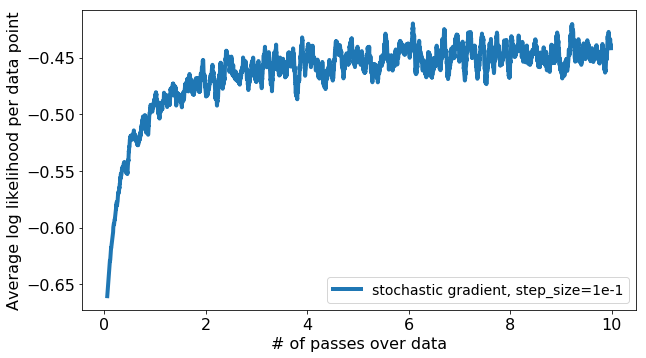

In [30]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

In [31]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)
print(num_iterations)
coefficients_sgd_200, log_likelihood_sgd_200 = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

95400
Iteration     0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data point

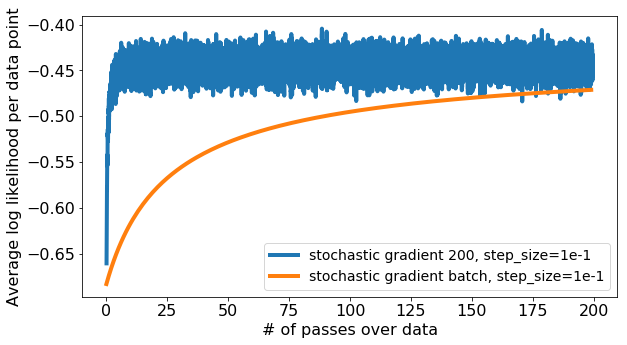

In [32]:
make_plot(log_likelihood_sgd_200, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient 200, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='stochastic gradient batch, step_size=1e-1')

In [33]:
step_size = 1e-4
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)
print(num_iterations)
coefficients_sgd_1e_4, log_likelihood_sgd_1e_4 = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

4770
Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [

In [34]:
step_size = 1e-3
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd_1e_3, log_likelihood_sgd_1e_3 = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

In [35]:
step_size = 1e-2
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd_1e_2, log_likelihood_sgd_1e_2 = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

In [36]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd_1e_1, log_likelihood_sgd_1e_1 = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

In [37]:
step_size = 1e0
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd_1e_0, log_likelihood_sgd_1e_0 = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

In [38]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd_1e__1, log_likelihood_sgd_1e__1 = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

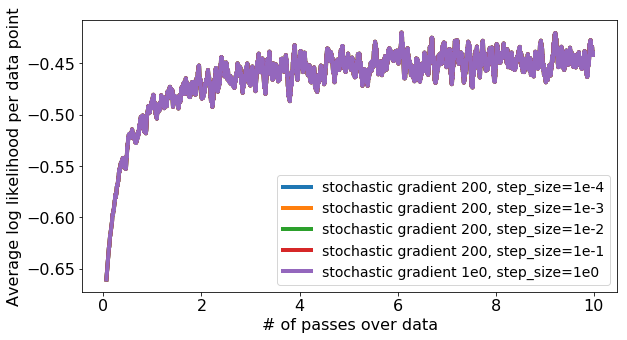

In [43]:
make_plot(log_likelihood_sgd_1e_4, len_data=len(train_data), batch_size=100,
          smoothing_window=30, label='stochastic gradient 200, step_size=1e-4')
make_plot(log_likelihood_sgd_1e_3, len_data=len(train_data), batch_size=100,
          smoothing_window=30, label='stochastic gradient 200, step_size=1e-3')
make_plot(log_likelihood_sgd_1e_2, len_data=len(train_data), batch_size=100,
          smoothing_window=30, label='stochastic gradient 200, step_size=1e-2')
make_plot(log_likelihood_sgd_1e_1, len_data=len(train_data), batch_size=100,
          smoothing_window=30, label='stochastic gradient 200, step_size=1e-1')
make_plot(log_likelihood_sgd_1e_0, len_data=len(train_data), batch_size=100,
          smoothing_window=30, label='stochastic gradient 1e0, step_size=1e0')
#make_plot(log_likelihood_sgd_1e__1, len_data=len(feature_matrix_train), batch_size=100,
         # smoothing_window=30, label='stochastic gradient 200, step_size=1e1')

In [44]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points in batch [01000

Iteration 4769: Average log likelihood (of data points in batch [47600:47700]) = -0.56306331
Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900

Iteration 4000: Average log likelihood (of data points in batch [18400:18500]) = -2.48469535
Iteration 4769: Average log likelihood (of data points in batch [47600:47700]) = -2.48789827
Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -2.44471310
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -36.66862050
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -25.49870239
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -40.14565040
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -27.03748522
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -32.62294582
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -inf
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -37.30720216
Iteration    8: Average log likelihood (of data points in batch [00800:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Iteration  200: Average log likelihood (of data points in batch [20000:20100]) = -4.03766272
Iteration  300: Average log likelihood (of data points in batch [30000:30100]) = -inf
Iteration  400: Average log likelihood (of data points in batch [40000:40100]) = -7.07561661


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Iteration  500: Average log likelihood (of data points in batch [02300:02400]) = -2.47123086
Iteration  600: Average log likelihood (of data points in batch [12300:12400]) = -23.91852791
Iteration  700: Average log likelihood (of data points in batch [22300:22400]) = -7.89629710
Iteration  800: Average log likelihood (of data points in batch [32300:32400]) = -8.12971084
Iteration  900: Average log likelihood (of data points in batch [42300:42400]) = -7.66241219
Iteration 1000: Average log likelihood (of data points in batch [04600:04700]) = -4.49352166
Iteration 2000: Average log likelihood (of data points in batch [09200:09300]) = -14.72585803
Iteration 3000: Average log likelihood (of data points in batch [13800:13900]) = -2.07118119
Iteration 4000: Average log likelihood (of data points in batch [18400:18500]) = -5.72804681
Iteration 4769: Average log likelihood (of data points in batch [47600:47700]) = -27.59102792


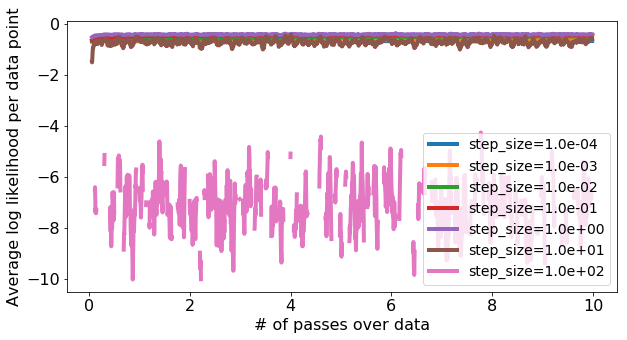

In [47]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

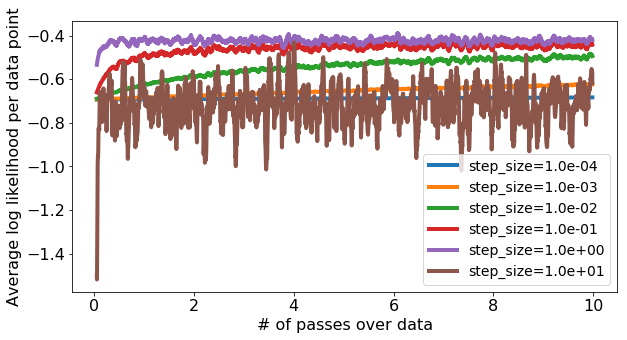

In [45]:
for step_size in np.logspace(-4, 2, num=7)[0:6]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)


In [46]:
np.logspace(-4, 2, num=7)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])